In [1]:
from neo import NeoMatlabIO
import numpy as np
import matplotlib.pyplot as plt
import plot_utils as u
from pathlib import Path
import scipy.signal as signal

In [2]:
colors = {
    "pyramidal": "#1446A0",
    "interneuron": "#929982",
    "nostim": "#326273",
    "stim": "#FF8248",
    "modulation": "#CCFF66",
}

In [3]:
open_dir = Path("cortex_lfp") / "OPEN-20240213184346-1"
zero_dir = Path("cortex_lfp") / "ZERO-20240213183346-1"

In [4]:
ctx_lfp_dir_zero = zero_dir / "Cortical_Pop"
interneuron_lfp_dir_zero = zero_dir / "Interneuron_Pop"

In [5]:
ctx_lfp_dir_open = open_dir / "Cortical_Pop"
interneuron_lfp_dir_open = open_dir / "Interneuron_Pop"

In [6]:
electrode_count = 3
electrode_distance = 0.4
excluded_radius = 0.06
min_radius = 0.01
max_radius = 1

sigma = 0.27

In [7]:
position_ctx = u.generate_random_cell_xy_positions(min_radius, max_radius, 100)
position_int = u.generate_random_cell_xy_positions(min_radius, max_radius, 100)

electrode_y = u.generate_electrode_positions(electrode_count, electrode_distance)

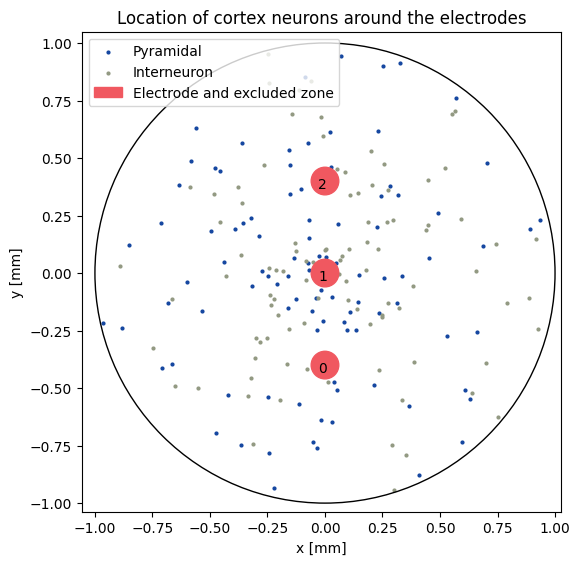

In [8]:
u.plot_ctx_cell_and_electrode_location(
    position_ctx,
    position_int,
    ([0 for _ in electrode_y], electrode_y),
    excluded_radius,
    max_radius
)

In [9]:
# %matplotlib widget
# plt.figure()
# plt.plot(tt, lfp_ctx, color="#1446A0", alpha=0.6)
# plt.plot(tt, lfp_int, color="#929982", alpha=0.6)
# plt.plot(tt, lfp_both, color="black") 
# plt.legend(["Ctx", "Interneuron", "LFP"])
# plt.xlim([3400, 3901])
# plt.xlabel("Time [ms]")
# plt.ylabel("Voltage [$\mu$V]")

In [10]:
tt_zero, electrode_lfp_zero = u.compute_cortical_lfp(
    ctx_lfp_dir_zero,
    interneuron_lfp_dir_zero,
    electrode_y,
    position_ctx,
    position_int,
    excluded_radius,
    sigma,
    )


In [11]:
tt_open, electrode_lfp_open = u.compute_cortical_lfp(
    ctx_lfp_dir_open,
    interneuron_lfp_dir_open,
    electrode_y,
    position_ctx,
    position_int,
    excluded_radius,
    sigma,
    )


In [12]:
tt = np.loadtxt("../../Cortex_BasalGanglia_DBS_model/burst_times_1.txt", delimiter=",")
aa = np.loadtxt("../../Cortex_BasalGanglia_DBS_model/burst_level_1.txt", delimiter=",")
stt, modulation_signal = u.burst_txt_to_signal(tt, aa, 10_000, 16_000, 0.01)

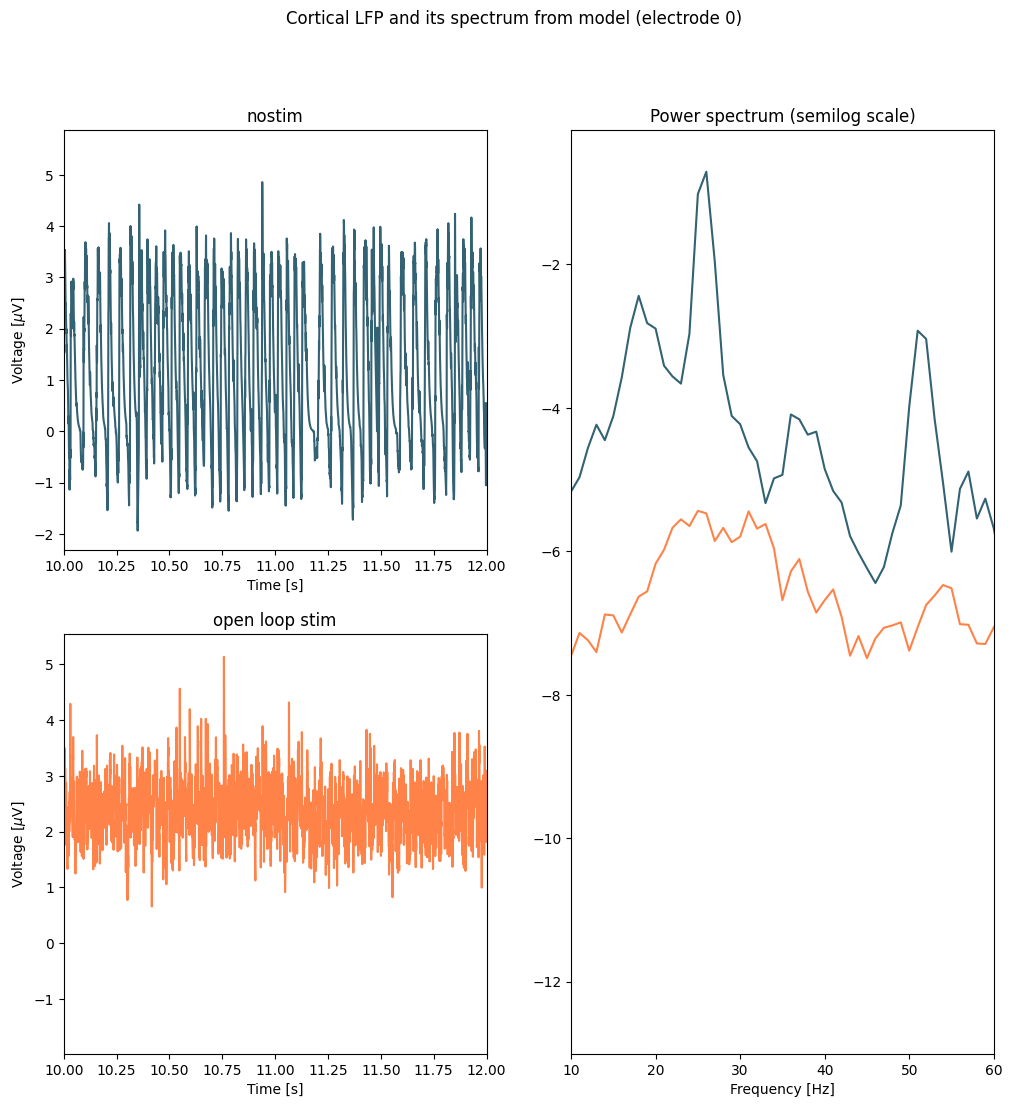

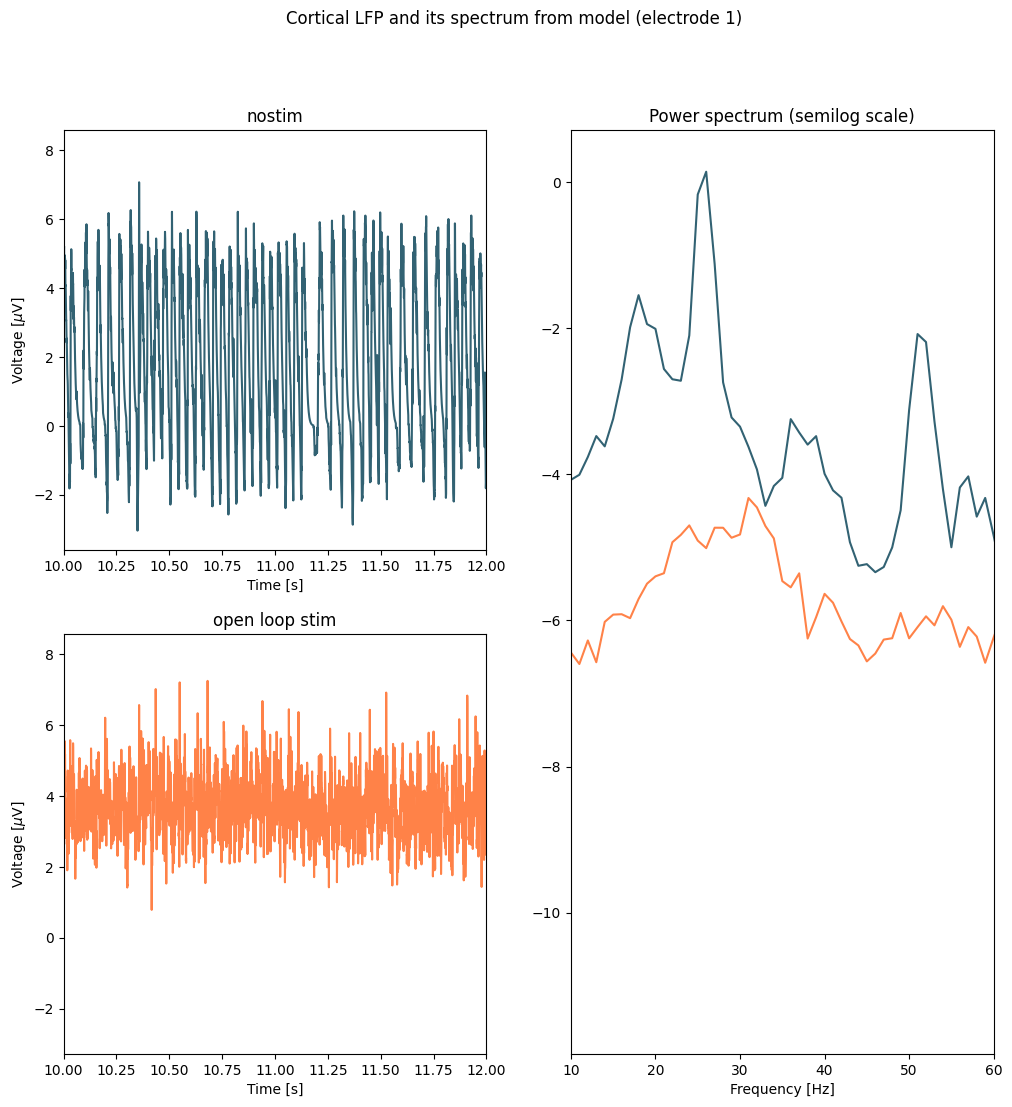

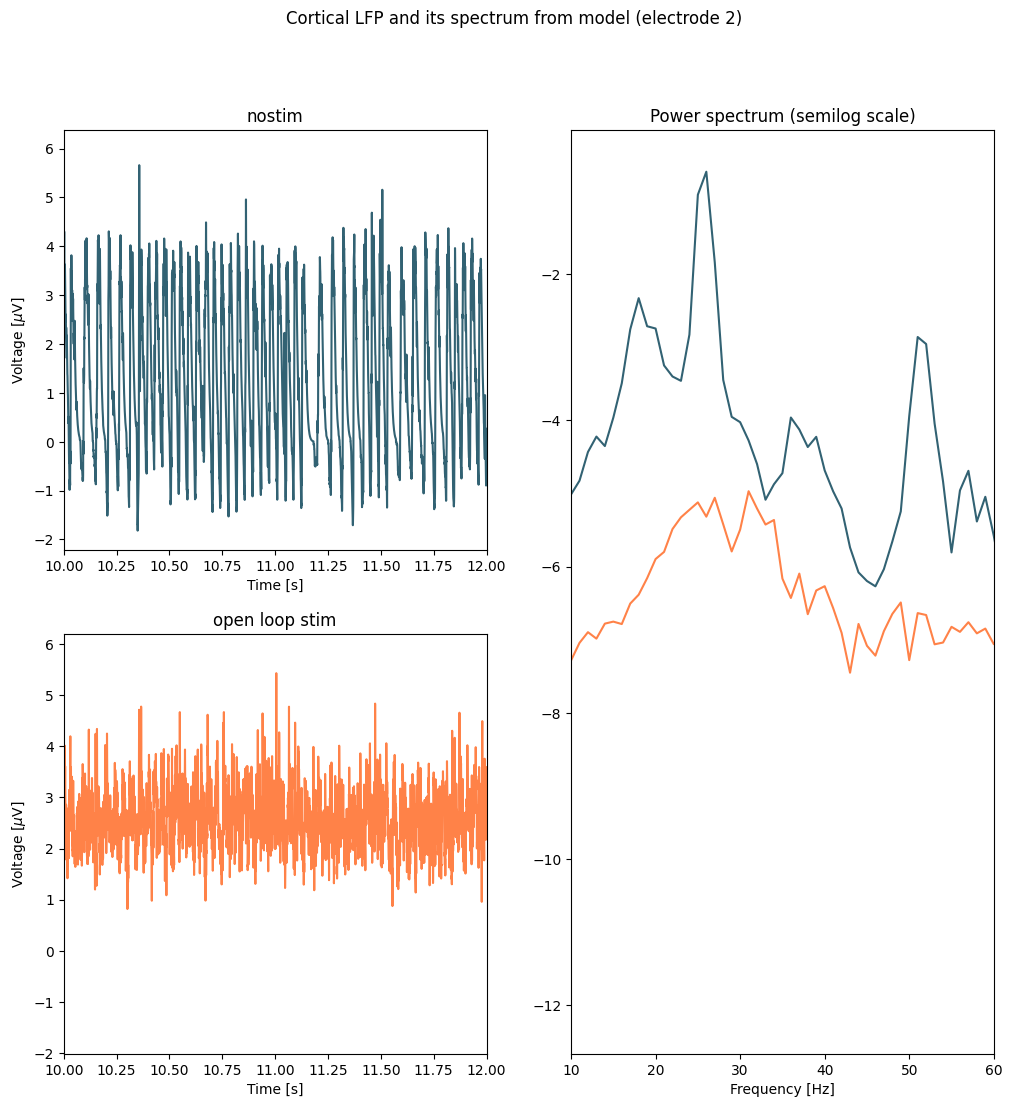

In [48]:
s = 10
e = 12

show_modulation = False

for i in range(electrode_count):
    fig = plt.figure(figsize=(12, 12))
    ax_voltage_nostim = fig.add_subplot(2, 2, 1)
    ax_voltage_stim = fig.add_subplot(2, 2, 3, sharex=ax_voltage_nostim)
    ax_spectrum = fig.add_subplot(1, 2, 2)

    elfp = electrode_lfp_zero[i]
    ax_voltage_nostim.plot(tt_zero / 1000, elfp, color=colors["nostim"])
    f, pxx = signal.welch(elfp[tt_zero >= 10_000], fs=2000, window="hamming", nperseg=2000)
    ax_spectrum.plot(f, np.log(pxx), color=colors["nostim"])
    if show_modulation:
        ax_voltage_nostim.plot(stt / 1000, modulation_signal + np.mean(elfp[tt_zero >= 10_000]), color=colors["modulation"])
    ax_voltage_nostim.set_xlim([s, e])
    ax_voltage_nostim.set_xlabel("Time [s]")
    ax_voltage_nostim.set_ylabel("Voltage [$\mu$V]")
    ax_voltage_nostim.set_title("nostim")

    elfp = electrode_lfp_open[i]
    ax_voltage_stim.plot(tt_open / 1000, elfp, color=colors["stim"])
    f, pxx = signal.welch(elfp[tt_zero >= 10_000], fs=2000, window="hamming", nperseg=2000)
    ax_spectrum.plot(f, np.log(pxx), color=colors["stim"])
    if show_modulation:
        ax_voltage_stim.plot(stt / 1000, modulation_signal + np.mean(elfp[tt_open >= 10_000]), color=colors["modulation"])
    ax_voltage_stim.set_xlim([s, e])
    ax_voltage_stim.set_xlabel("Time [s]")
    ax_voltage_stim.set_ylabel("Voltage [$\mu$V]")
    ax_voltage_stim.set_title("open loop stim")

    ax_spectrum.set_title("Power spectrum (semilog scale)")
    ax_spectrum.set_xlim([10, 60])
    ax_spectrum.set_xlabel("Frequency [Hz]")
    fig.suptitle(f"Cortical LFP and its spectrum from model (electrode {i})")


In [17]:
patient_data_dir = Path("C:\\Users\\Kuba Orlowski\\Downloads\\Charite project")
patient_stim_on_file = patient_data_dir / "sub-EL006_ses-EcogLfpMedOff01_task-Rest_acq-StimOnR.mat"
patient_stim_off_file = patient_data_dir / "sub-EL006_ses-EcogLfpMedOff01_task-Rest_acq-StimOff.mat"

In [31]:
import mat73
patient_stim_off_data = mat73.loadmat(patient_stim_off_file, use_attrdict=True)
patient_stim_on_data = mat73.loadmat(patient_stim_on_file, use_attrdict=True)

In [37]:
tt_off = patient_stim_off_data["data"].time[0]
tt_on = patient_stim_on_data["data"].time[0]
fs_off = 1 / (tt_off[1] - tt_off[0])
fs_on = 1 / (tt_on[1] - tt_on[0])

f_on, p_on = signal.welch(patient_stim_on_data["data"]["trial"][0][1:8, :], fs=fs_on, window="hamming", nperseg=int(fs_on))
f_off, p_off = signal.welch(patient_stim_off_data["data"]["trial"][0][1:8, :], fs=fs_off, window="hamming", nperseg=int(fs_off))

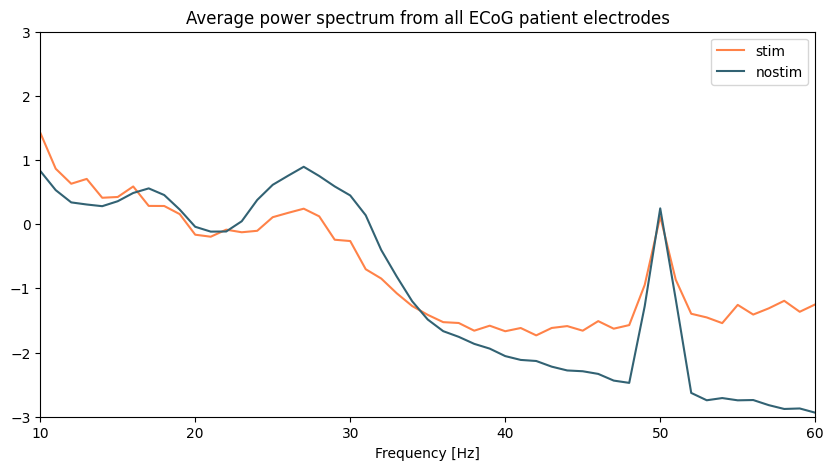

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(f_on, np.log(np.mean(p_on, axis=0)), color=colors["stim"])
plt.plot(f_off, np.log(np.mean(p_off, axis=0)), color=colors["nostim"])
plt.xlim([10, 60])
plt.ylim([-3, 3])
plt.xlabel("Frequency [Hz]")
plt.title("Average power spectrum from all ECoG patient electrodes")
plt.legend(["stim", "nostim"])

In [ ]:
stn_lfp_zero = NeoMatlabIO(Path("cortex_lfp") / "ZERO-20240213183346-1" / "STN_LFP.mat").read()[0].segments[0].analogsignals[0]
stn_lfp_open = NeoMatlabIO(Path("cortex_lfp") / "OPEN-20240213184346-1" / "STN_LFP.mat").read()[0].segments[0].analogsignals[0]


In [ ]:
dbs_zero = NeoMatlabIO(Path("cortex_lfp") / "ZERO-20240213183346-1" / "DBS_Signal.mat").read()[0].segments[0].analogsignals[0]
dbs_open = NeoMatlabIO(Path("cortex_lfp") / "OPEN-20240213184346-1" / "DBS_Signal.mat").read()[0].segments[0].analogsignals[0]

Text(0.5, 1.0, 'STN LFP power spectrum')

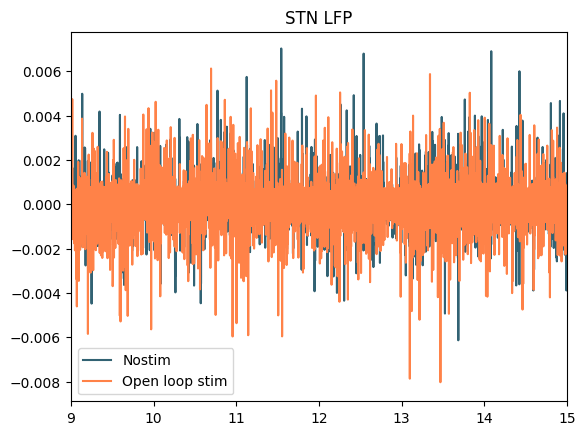

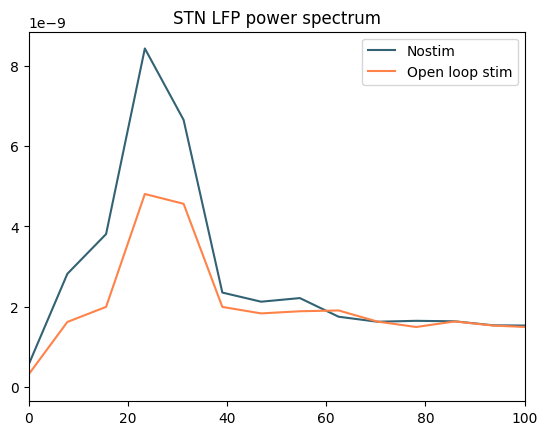

In [ ]:
plt.figure()
plt.plot(stn_lfp_zero.times / 1000, stn_lfp_zero, color=colors["nostim"])
plt.plot(stn_lfp_open.times / 1000, stn_lfp_open, color=colors["stim"])
plt.xlim([9, 15])
plt.legend(["Nostim", "Open loop stim"])
plt.title("STN LFP")

f_open, pxx_open = signal.welch(stn_lfp_open.as_array().transpose()[0], 2000)
f_zero, pxx_zero = signal.welch(stn_lfp_zero.as_array().transpose()[0], 2000)

plt.figure()
plt.plot(f_zero, pxx_zero, color=colors["nostim"])
plt.plot(f_open, pxx_open, color=colors["stim"])
plt.xlim([0, 100])
plt.legend(["Nostim", "Open loop stim"])
plt.title("STN LFP power spectrum")
